# Cataract Classification

1. Contents
2. Import libraries
3. Set configurations and read metadata
4. Process Cataract dataset
5. Process Ocular disease recognition dataset
6. Create datasets
7. Build the model

In [1]:
# Essential Libraries

import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

Weights in neural networks are assigned at random. This is accomplished by the use of a random number generator, which generates numbers at random. Every time you start the network training procedure, your outcomes will be different. To acquire reliable results, you must fix the random seed so that you may experiment with other aspects of the network, like as the amount of neurons, hidden layers, and so on, without worrying about the random generator.

In [2]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# cataract dataset
IMG_ROOT = 'datasets/cataractdataset/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = 'datasets/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('datasets/ocular-disease-recognition-odir5k/ODIR-5K/data.xlsx')

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [4]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
0,datasets/cataractdataset/dataset\1_normal/NL_0...,0
1,datasets/cataractdataset/dataset\1_normal/NL_0...,0
2,datasets/cataractdataset/dataset\1_normal/NL_0...,0
3,datasets/cataractdataset/dataset\1_normal/NL_0...,0
4,datasets/cataractdataset/dataset\1_normal/NL_0...,0
...,...,...
596,datasets/cataractdataset/dataset\3_retina_dise...,0
597,datasets/cataractdataset/dataset\3_retina_dise...,0
598,datasets/cataractdataset/dataset\3_retina_dise...,0
599,datasets/cataractdataset/dataset\3_retina_dise...,0


In [5]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts()) 

Number of normal and cataract images
0    601
Name: cataract, dtype: int64


In [6]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [7]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [8]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [9]:
le_df.head()

,cataract,paths
0,1,datasets/ocular-disease-recognition-odir5k/ODI...
1,0,datasets/ocular-disease-recognition-odir5k/ODI...
2,0,datasets/ocular-disease-recognition-odir5k/ODI...
3,0,datasets/ocular-disease-recognition-odir5k/ODI...
4,0,datasets/ocular-disease-recognition-odir5k/ODI...


In [10]:
re_df.head()

,cataract,paths
0,0,datasets/ocular-disease-recognition-odir5k/ODI...
1,0,datasets/ocular-disease-recognition-odir5k/ODI...
2,0,datasets/ocular-disease-recognition-odir5k/ODI...
3,0,datasets/ocular-disease-recognition-odir5k/ODI...
4,0,datasets/ocular-disease-recognition-odir5k/ODI...


In [11]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


In [12]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [13]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,datasets/ocular-disease-recognition-odir5k/ODI...
81,1,datasets/ocular-disease-recognition-odir5k/ODI...
103,1,datasets/ocular-disease-recognition-odir5k/ODI...
119,1,datasets/ocular-disease-recognition-odir5k/ODI...
253,1,datasets/ocular-disease-recognition-odir5k/ODI...


In [14]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,datasets/cataractdataset/dataset\1_normal/NL_0...,0
1,datasets/cataractdataset/dataset\1_normal/NL_0...,0
2,datasets/cataractdataset/dataset\1_normal/NL_0...,0
3,datasets/cataractdataset/dataset\1_normal/NL_0...,0
4,datasets/cataractdataset/dataset\1_normal/NL_0...,0
...,...,...
1222,datasets/ocular-disease-recognition-odir5k/ODI...,0
1223,datasets/ocular-disease-recognition-odir5k/ODI...,0
1224,datasets/ocular-disease-recognition-odir5k/ODI...,0
1225,datasets/ocular-disease-recognition-odir5k/ODI...,0


In [15]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [16]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|████████████████████████████████████████| 246/246 [00:16<00:00, 14.80it/s]


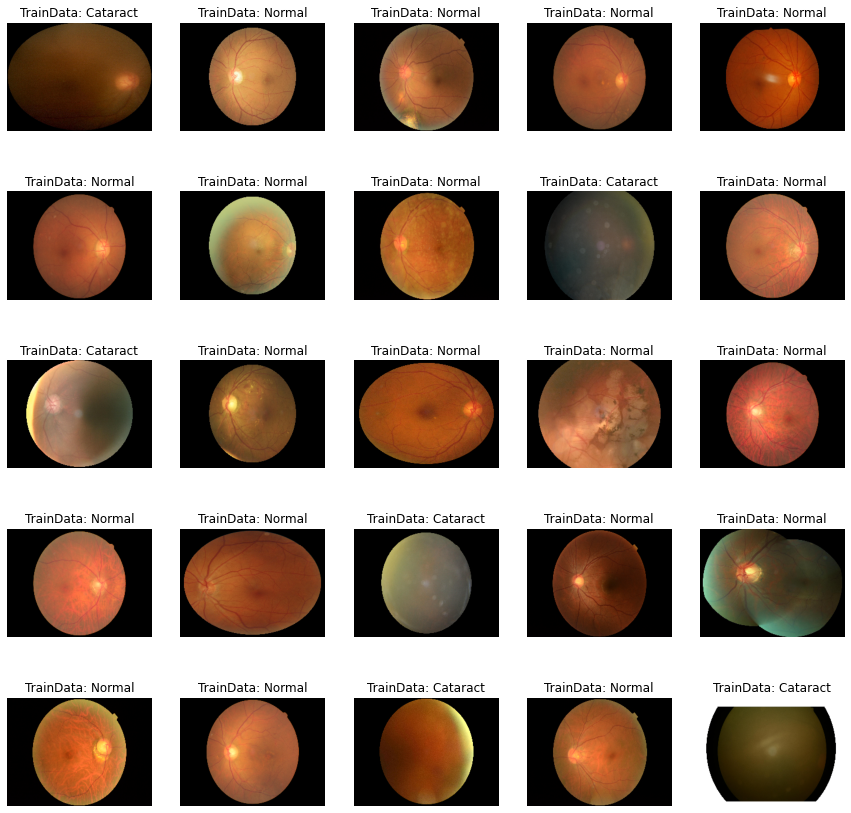

In [17]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

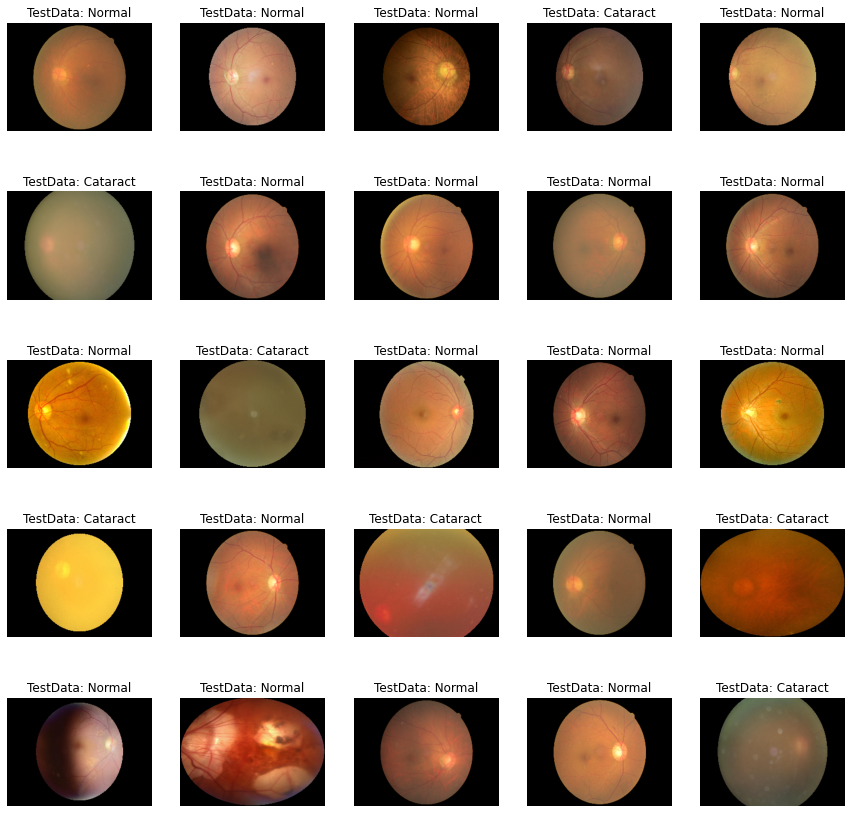

In [18]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [19]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [20]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 256, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 192, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 85, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 85, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 85, 16)        2

In [21]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/10
26/26 [==============================] - 78s 3s/step - loss: 1.0486 - accuracy: 0.7311 - val_loss: 0.5447 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/10
26/26 [==============================] - 74s 3s/step - loss: 1.1264 - accuracy: 0.7395 - val_loss: 0.5324 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/10
26/26 [==============================] - 71s 3s/step - loss: 0.7266 - accuracy: 0.8151 - val_loss: 0.5112 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
26/26 [==============================] - 76s 3s/step - loss: 0.7046 - accuracy: 0.8079 - val_loss: 0.4791 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 5/10
26/26 [==============================] - 86s 3s/step - loss: 0.7634 - accuracy: 0.7791 - val_loss: 0.4191 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 6/10
26/26 [==============================] - 88s 3s/step - loss: 1.0761 - accuracy: 0.7923 - val_loss: 0.5042 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 7/10
26/26 [==============================] - 78s 3s/step - loss: 0.8864 - a

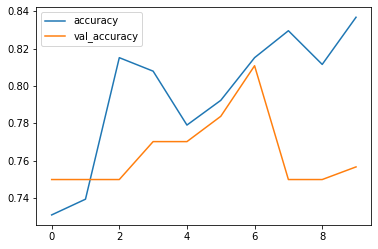

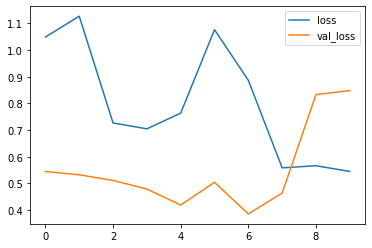

In [22]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=10,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [23]:
model.evaluate(test_imgs, test_df)

8/8 [==============================] - 7s 851ms/step - loss: 0.9058 - accuracy: 0.7439


[0.905763566493988, 0.7439024448394775]